In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 10 seconds. 424 already precompiled.


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
# solver_args = Dict(:adaptive => false, :dt => 0.01)

In [6]:
# spk_args = SpikingArgs(t_window = 0.01, 
#                     threshold = 0.001,
#                     solver=Heun(), 
#                     solver_args = solver_args)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [10]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [11]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [12]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [13]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

In [16]:
model, ps, st = build_mlp_f32(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.022104174 0.0044612987; 0.018899845 -0.09760291; … ; 0.13916312 -0.026716936; -0.21080716 0.043440487], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.87161916 -0.83025014 … -0.84057987 -0.8994507; -0.3154753 -0.3998432 … -0.030079616 0.67342687], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [17]:
spk_model, _, _ = build_spiking_mlp_f32(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.23785943 0.07556767; -0.06319771 -0.13431165; … ; -0.03468947 -0.026928129; 0.0034530966 -0.018008614], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.15850209 -1.3750875 … 0.042045895 0.3353048; 1.5121853 0.027519785 … -0.6878088 -1.3173012], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [18]:
y, _ = model(x, ps, st)

([-0.9817763738960664 0.9608504911863732 … 0.9884957419553746 0.9902470183079752; -0.053013716658721746 -0.022373927535505763 … -0.12411456237191373 -0.05344758878154678], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [19]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [20]:
y_spk.train.offset

0.5

In [21]:
p_spk = train_to_phase(y_spk);

In [22]:
size(p_spk)

(10, 2, 256)

In [23]:
size(y)

(2, 256)

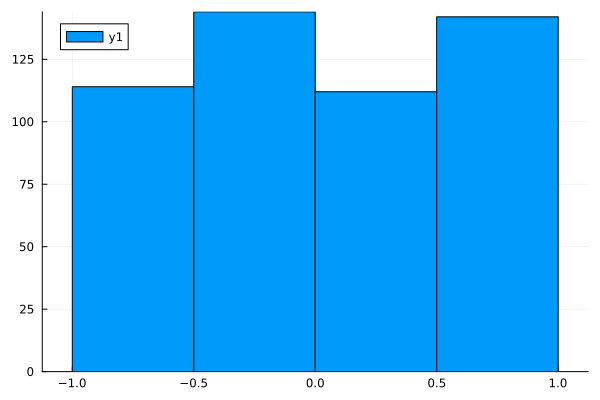

In [27]:
histogram(vec(p_spk[5,:,:]))

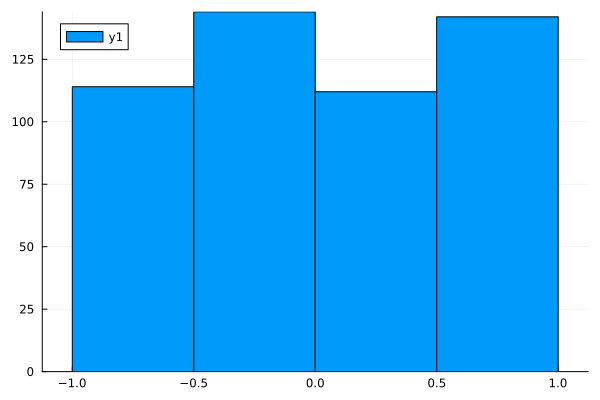

In [28]:
histogram(vec(p_spk[6,:,:]))

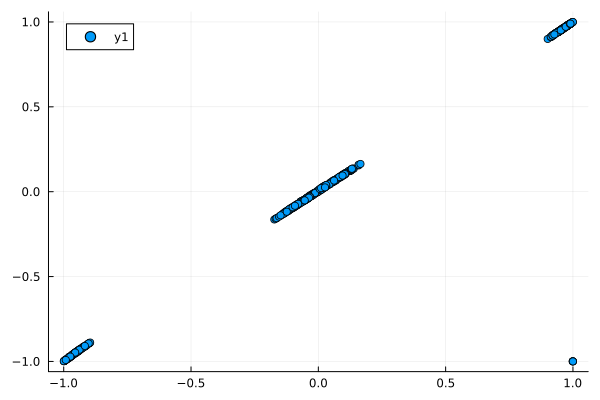

In [29]:
scatter(vec(y), vec(p_spk[5,:,:]))

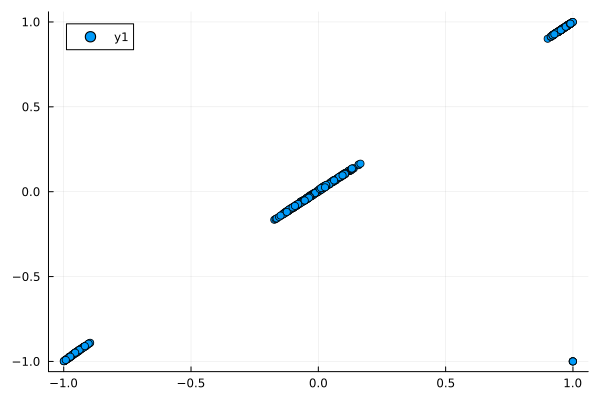

In [30]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [31]:
y |> size

(2, 256)

In [32]:
p_spk |> size

(10, 2, 256)

In [33]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9656482468699713
   0.9660648178402648
   0.9661687143369566
   0.9662140859540418
   0.9662388731949813
   0.9662541613544533
   0.9662643290837604
   0.9662714410207447
   0.7761938302833314

In [34]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.9908472023815197, 1.0630748851172755, 0.9905551344812954, 1.0766145191200653, 0.973124258990807, 1.0032917626575355, 0.966308600061165, 0.978753189293114, 0.9713270872089081, 0.9629775113700485  …  0.07897624643139446, 0.06850759790282211, 0.06231015578052274, 0.06978454383608713, 0.0800947848819977, 0.06824082764413862, 0.07999688900744659, 0.07972453176591007, 0.08496753850678977, 0.07249350958150097], (layer_1 = (bias = Float32[-0.1870782; 0.033379637;;], scale = Float32[0.8734139; 0.86004806;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.028946491 0.005387057; 0.0033044876 -0.09840185; … ; 0.13508473 -0.01793366; -0.23413888 0.011616429], bias_real = Float32[0.9969983, 0.9995214, 1.017481, 0.9951777, 0.9408524, 1.0127898, 0.94907403, 0.96817344, 1.0011506, 0.9349469  …  0.9700956, 0.97604376, 0.99281466, 1.0025088, 0.9959366, 1.0116773, 0.9649697, 0.9857106, 1.0044351, 0.9726991], bias_imag = Float32[-0.0061129835, 0.0025871785, 0.00134638

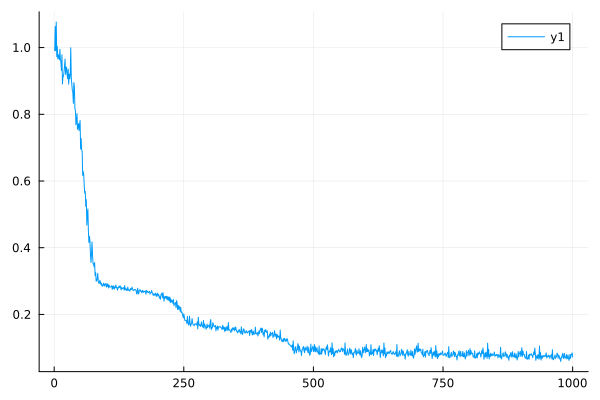

In [35]:
plot(losses)

In [36]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.07638025990993866, 0.968359375)

In [37]:
yt, _ = model(x, ps_train, st_train)

([-0.10330625845028736 0.20087058626322649 … 0.6290438740086592 0.5139956117946003; 0.37052742705555136 0.27855221613694037 … 0.10673552754915093 -0.02543388159347499], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [38]:
ps_train

(layer_1 = (bias = Float32[-0.1870782; 0.033379637;;], scale = Float32[0.8734139; 0.86004806;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.028946491 0.005387057; 0.0033044876 -0.09840185; … ; 0.13508473 -0.01793366; -0.23413888 0.011616429], bias_real = Float32[0.9969983, 0.9995214, 1.017481, 0.9951777, 0.9408524, 1.0127898, 0.94907403, 0.96817344, 1.0011506, 0.9349469  …  0.9700956, 0.97604376, 0.99281466, 1.0025088, 0.9959366, 1.0116773, 0.9649697, 0.9857106, 1.0044351, 0.9726991], bias_imag = Float32[-0.0061129835, 0.0025871785, 0.0013463844, -0.017203495, 0.06310631, 0.00021533766, -0.04673661, 0.05928495, 0.00046173623, -0.019851472  …  -0.022638872, -0.047216747, -0.014965471, 0.008315789, -0.0012552317, -0.008034801, -0.016628757, 0.016650084, 0.020351322, -0.039371967]), layer_5 = (weight = Float32[0.8991686 -0.8030125 … -0.8121431 -0.8741842; -0.3429668 -0.42367646 … -0.061776515 0.6530509], bias_real = Float32[1.0276608, 0.97301114], bias_

In [39]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [40]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

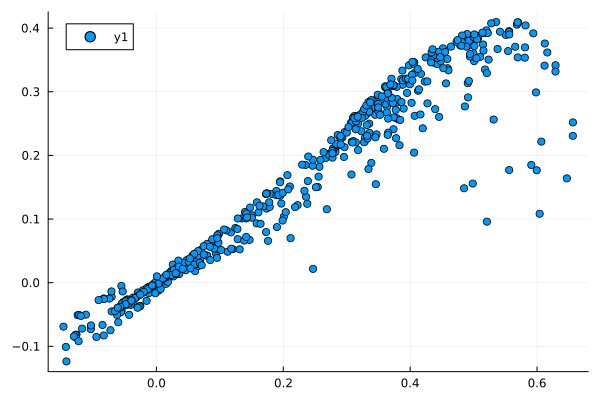

In [41]:
scatter(vec(yt), vec(pt[5,:,:]))

In [42]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 -0.11103476781552735
  0.827396539080224
  0.8915276941579184
  0.9290247526291309
  0.9524922767313215
  0.9678739753760115
  0.978101551124894
  0.9848570289120336
  0.9892731348014119
  0.9908689054892077

In [28]:
model, ps, st = build_mlp(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.094822 0.07953795; 0.0360204 0.042711686; … ; -0.0078024575 -0.12494607; -0.12408377 0.032318436], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.6479921 0.9973458 … 0.8942231 0.119449; 0.02835401 0.07225186 … -1.620841 0.274164], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [29]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.100097165 -0.08400563; -0.043830868 0.08561577; … ; -0.11423786 -0.01003357; -0.027015472 0.08503423], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.36617383 -0.60858494 … -1.2242941 0.94335234; -1.4080956 0.5885511 … -0.37727275 0.16353247], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [30]:
x

2×256 adjoint(::Matrix{Float64}) with eltype Float64:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [31]:
y, _ = model(x, ps, st)

([0.9984732985459185 -0.9797485534991318 … -0.9951893435401068 -0.996515470491313; 0.039808065964501024 -0.03788517979155755 … 0.011828517558205147 -0.0026628943572998384], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [32]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [33]:
y_spk.train.offset

0.5

In [34]:
p_spk = train_to_phase(y_spk);

In [35]:
size(p_spk)

(10, 2, 256)

In [36]:
size(y)

(2, 256)

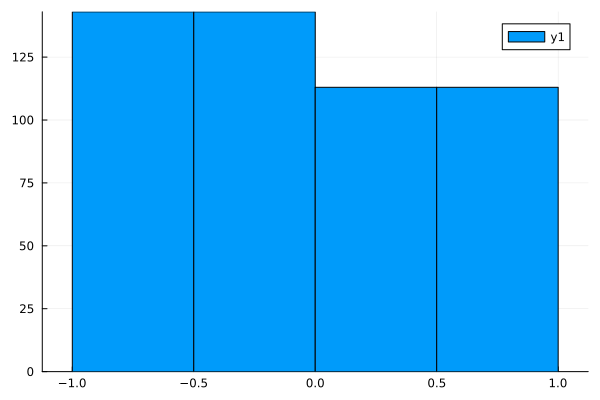

In [37]:
histogram(vec(p_spk[5,:,:]))

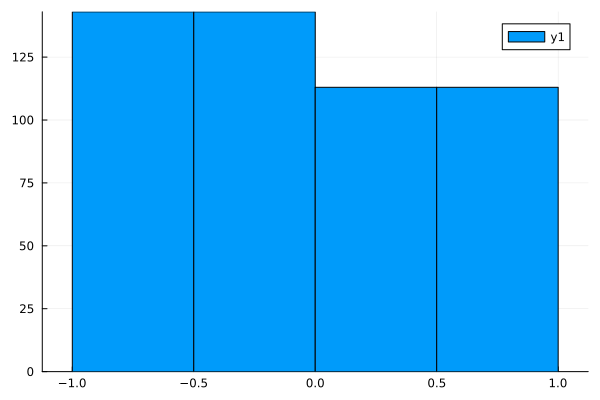

In [38]:
histogram(vec(p_spk[6,:,:]))

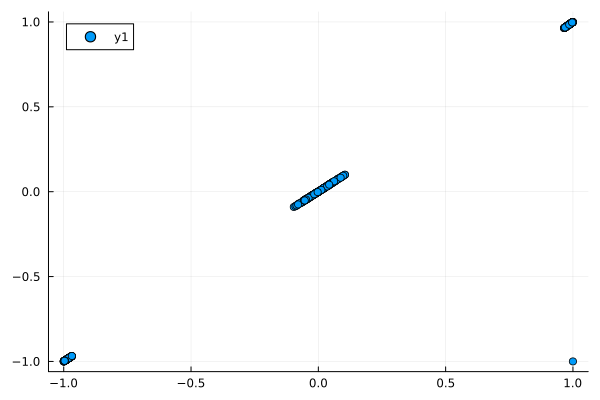

In [39]:
scatter(vec(y), vec(p_spk[5,:,:]))

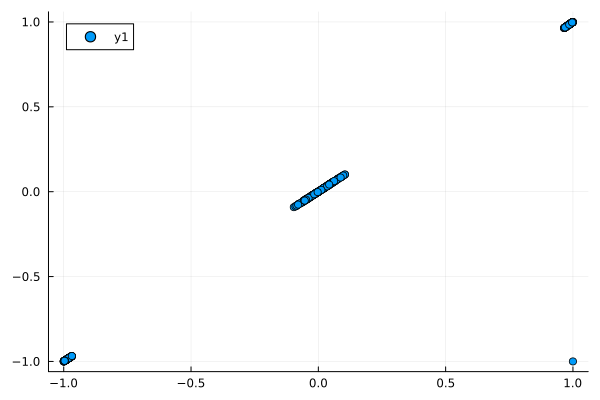

In [40]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [41]:
y |> size

(2, 256)

In [42]:
p_spk |> size

(10, 2, 256)

In [43]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9838514761549562
   0.9919306648833871
   0.9919406522448713
   0.991944448530331
   0.9919462688955125
   0.991947270491864
   0.9919478761678041
   0.9919482666086792
   0.5841604724283038

In [44]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.9961153471150249, 1.033883788437928, 0.9740514490272801, 1.0485034553965644, 0.971943098201699, 1.001719815585228, 0.9785053384851712, 0.998451737794528, 0.9766255685411351, 0.9800516693129682  …  0.1220430226954413, 0.10652221367606794, 0.11393911370319097, 0.10704740308719689, 0.13006702687845342, 0.1161523216643199, 0.13224100146510137, 0.1198318160424448, 0.11555601318706125, 0.1242396626643127], (layer_1 = (bias = Float32[0.22153577; -0.32666698;;], scale = Float32[0.83617824; 0.7212579;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.07049604 0.13463491; 0.037404582 -0.1182238; … ; 0.0016298004 -0.14496425; -0.12524779 0.038931694], bias = ComplexF32[0.9992698f0 + 0.035501998f0im, 0.9983737f0 + 0.01078772f0im, 0.9997097f0 - 0.015717475f0im, 0.99916255f0 - 0.022677487f0im, 0.99966276f0 - 0.029518178f0im, 0.9989744f0 + 0.034319635f0im, 1.0009269f0 + 0.0072684977f0im, 1.0005833f0 - 0.0035292136f0im, 1.0002183f0 - 0.0027755818f0im, 1.0001363f0

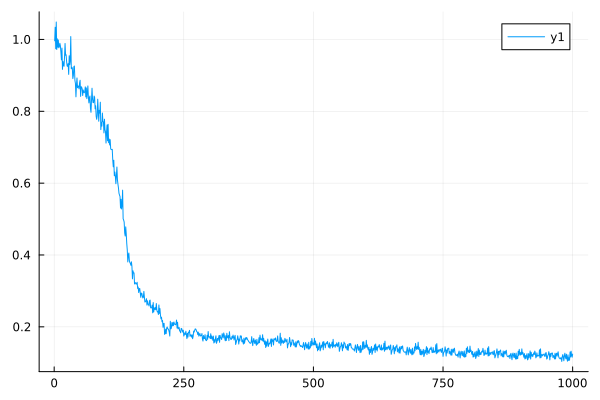

In [45]:
plot(losses)

In [46]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.11947335249310953, 0.957421875)

In [47]:
yt, _ = model(x, ps_train, st_train)

([0.2734683210454845 0.04299945261552349 … 0.339600834806255 0.34686519128288096; 0.3854099408090606 0.4937473573616073 … 0.08900876257047714 0.00556372921723711], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [48]:
ps_train

(layer_1 = (bias = Float32[0.22153577; -0.32666698;;], scale = Float32[0.83617824; 0.7212579;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.07049604 0.13463491; 0.037404582 -0.1182238; … ; 0.0016298004 -0.14496425; -0.12524779 0.038931694], bias = ComplexF32[0.9992698f0 + 0.035501998f0im, 0.9983737f0 + 0.01078772f0im, 0.9997097f0 - 0.015717475f0im, 0.99916255f0 - 0.022677487f0im, 0.99966276f0 - 0.029518178f0im, 0.9989744f0 + 0.034319635f0im, 1.0009269f0 + 0.0072684977f0im, 1.0005833f0 - 0.0035292136f0im, 1.0002183f0 - 0.0027755818f0im, 1.0001363f0 + 0.014975295f0im  …  1.0006096f0 + 0.01506164f0im, 0.99983066f0 - 0.019312382f0im, 0.9946108f0 + 0.067727074f0im, 0.99869496f0 - 0.041519728f0im, 0.9998666f0 + 0.019738678f0im, 0.9998891f0 + 0.0012366308f0im, 0.99816746f0 - 0.052348383f0im, 1.0002588f0 + 0.022161648f0im, 0.9987104f0 + 0.038418442f0im, 1.0010985f0 - 0.0016585696f0im]), layer_5 = (weight = Float32[-0.55982274 1.0873696 … 0.98756236 0.2091046

In [49]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [50]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

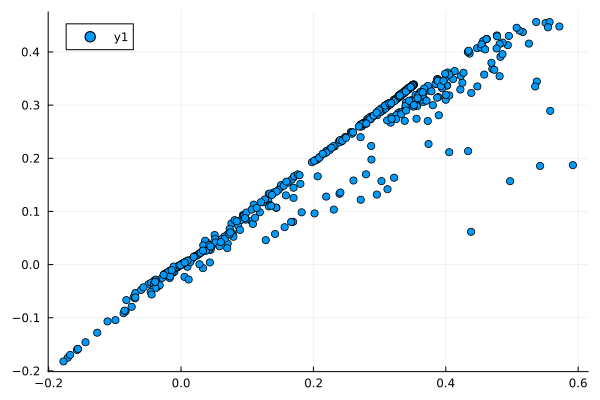

In [53]:
scatter(vec(yt), vec(pt[8,:,:]))

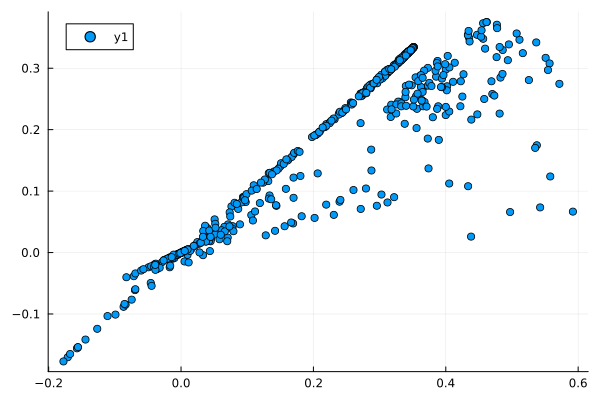

In [ ]:
scatter(vec(yt), vec(pt[5,:,:]))

In [52]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 0.03636734249898397
 0.6324739938855687
 0.7669303177796922
 0.8479819202441236
 0.8970469758275113
 0.927978528263444
 0.9486170723070918
 0.963140813379197
 0.9737022961808001
 0.9797038286661225